# Table of Contents

- [Preprocessing for Clustering](#preprocessing-for-clustering)
  - [Merging DataFrames](#merging-dataframes)
  - [Feature selection](#feature-selection)
  - [Pairplots, correlation matrix and analysis](#pairplots,-correlation-matrix-and-analysis)
  - [Scaling](#scaling)
- [K-means Clustering](#k-means-clustering)
- [DBSCAN Clustering](#dbscan-clustering)
- [Hierarchical Clustering](#hierarchical-clustering)
- [Cluster Evaluation and Interpretation](#cluster-evaluation-and-interpretation)
- [Final observations](#final-observations)


# Preprocessing for Clustering

Constants:

In [83]:
# How many samples to take for each test
SAMPLE_SIZE = 1000

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns

# Autoreload allows the notebook to dynamically load code: if we update some helper functions outside of the notebook, we do not need to reload the notebook.
%load_ext autoreload
%autoreload 2

# All auxiliary code is in ../src
# code taken from: https://github.com/data-mining-UniPI/teaching24/tree/main/src
import sys
sys.path.append("./src/")

# Set style for seaborn
sns.set_theme(style="darkgrid")

# Other available themes:
# sns.set_theme(style="whitegrid")
# sns.set_theme(style="dark")
# sns.set_theme(style="white")
# sns.set_theme(style="ticks")

# Load datasets
cyclists_df = pd.read_pickle('cyclists_transformed.pkl')
races_df = pd.read_pickle('races_transformed.pkl')

# Display info
print("Cyclists DataFrame:")
print(cyclists_df.info())
print("\nRaces DataFrame:")
print(races_df.info())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cyclists DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _url                6134 non-null   string 
 1   name                6134 non-null   string 
 2   birth_year          6134 non-null   Int64  
 3   weight              6134 non-null   Int64  
 4   height              6134 non-null   Int64  
 5   nationality         6134 non-null   string 
 6   BMI                 3071 non-null   Float64
 7   races_participated  6134 non-null   int64  
dtypes: Float64(1), Int64(3), int64(1), string(3)
memory usage: 407.5 KB
None

Races DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 589704 entries, 0 to 589864
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------

## Merging DataFrames

In [85]:
merged_df = pd.merge(races_df, cyclists_df, left_on='cyclist', right_on='_url')
merged_df.head()

,_url_x,name_x,points,length,climb_total,profile,startlist_quality,position,cyclist,cyclist_age,...,climb_length,length_catogory,_url_y,name_y,birth_year,weight,height,nationality,BMI,races_participated
0,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,0,sean-kelly,22,...,short 0-25%,medium 25-50%,sean-kelly,Sean Kelly,1956,77,180,Ireland,23.8,629
1,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,1,gerrie-knetemann,27,...,short 0-25%,medium 25-50%,gerrie-knetemann,Gerrie Knetemann,1951,69,181,Netherlands,<NA>,271
2,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,2,rene-bittinger,24,...,short 0-25%,medium 25-50%,rene-bittinger,René Bittinger,1954,69,174,France,22.8,146
3,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,3,joseph-bruyere,30,...,short 0-25%,medium 25-50%,joseph-bruyere,Joseph Bruyère,1948,71,188,Belgium,<NA>,48
4,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,4,sven-ake-nilsson,27,...,short 0-25%,medium 25-50%,sven-ake-nilsson,Sven-Åke Nilsson,1951,63,172,Sweden,21.3,145


In [86]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589704 entries, 0 to 589703
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   _url_x              589704 non-null  string        
 1   name_x              589704 non-null  string        
 2   points              589227 non-null  Int64         
 3   length              589704 non-null  Int64         
 4   climb_total         442692 non-null  Int64         
 5   profile             441607 non-null  Int64         
 6   startlist_quality   589704 non-null  int64         
 7   position            589704 non-null  int64         
 8   cyclist             589704 non-null  string        
 9   cyclist_age         589704 non-null  Int64         
 10  cyclist_team        430630 non-null  string        
 11  delta               589704 non-null  Int64         
 12  year                589704 non-null  int32         
 13  race_day            589704 no

## Feature selection

In [87]:
# Select features from cyclists_df

cyclists_features_list = ['birth_year', 'weight', 'races_participated']
races_features_list = ['climb_total', 'startlist_quality', 'delta']

cyclists_features = cyclists_df[cyclists_features_list]
races_features = races_df[races_features_list]
merged_features = merged_df[cyclists_features_list + races_features_list]

# Drop rows with missing values
cyclists_features = cyclists_features.dropna() # TODO: dovrebbero essere 0. verificare, e poi rimuovere questa riga.
races_features = races_features.dropna()
merged_features = merged_features.dropna()

## Sampling

In [88]:
# Perform sampling
cyclists_features = cyclists_features.sample(n=SAMPLE_SIZE, random_state=42)
races_features = races_features.sample(n=SAMPLE_SIZE, random_state=42)
merged_features = merged_features.sample(n=SAMPLE_SIZE, random_state=42)

## Pairplots, correlation matrix and analysis

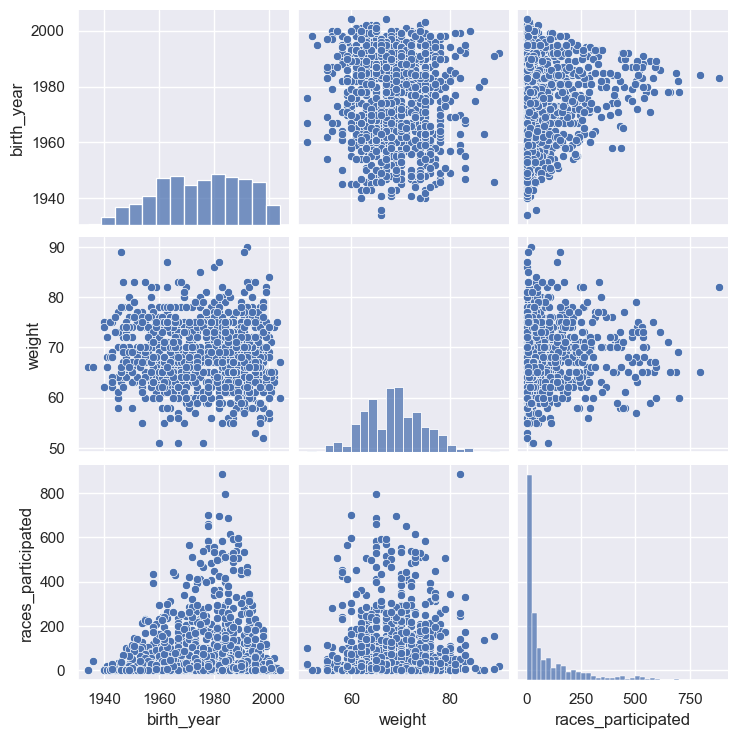

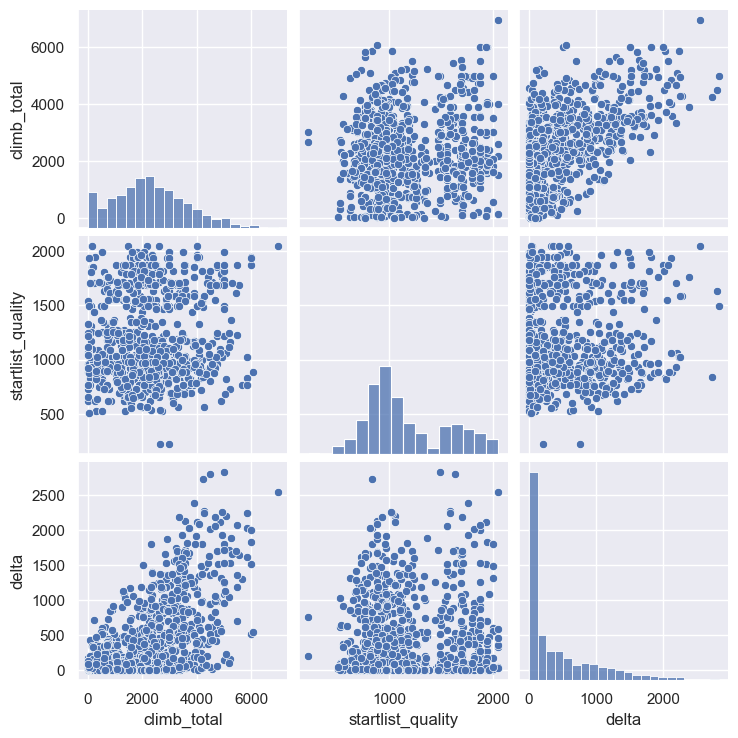

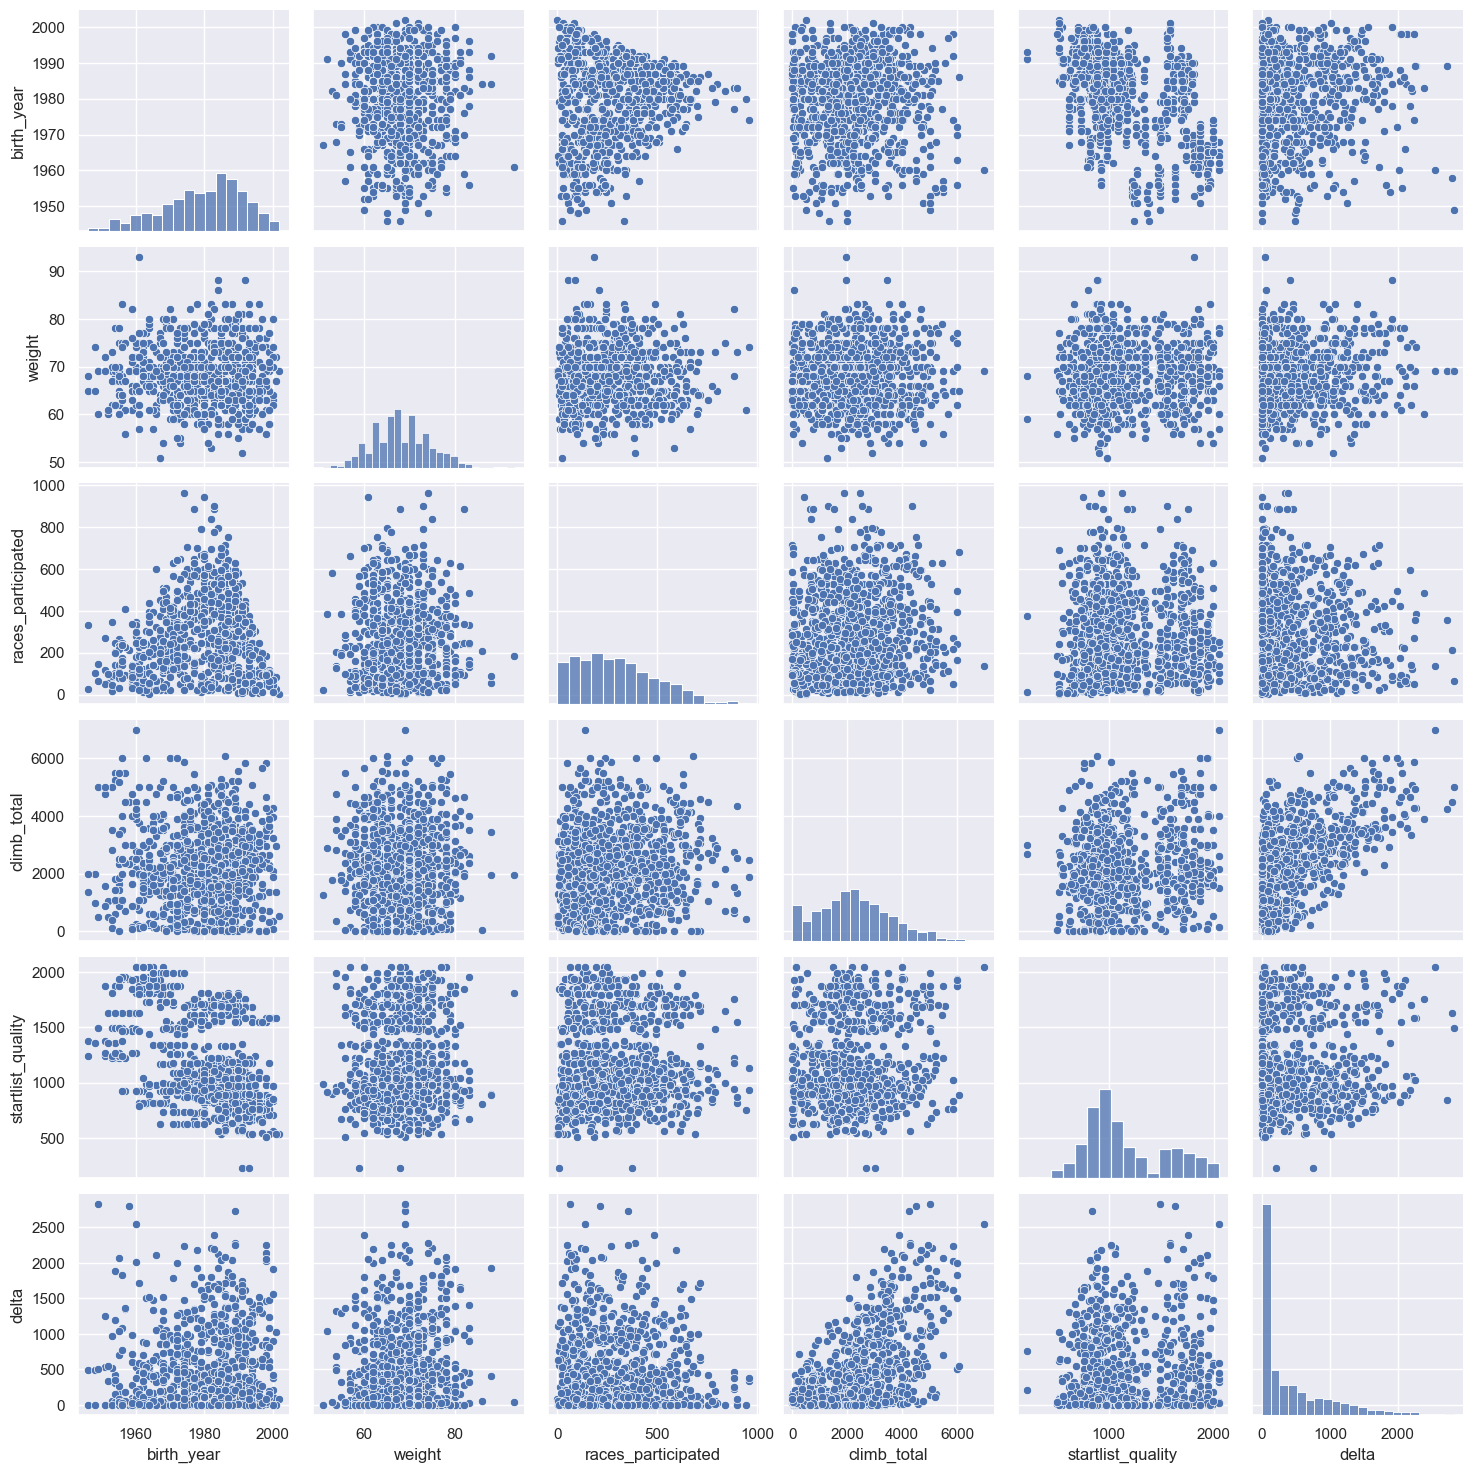

In [89]:
# Plot the pairplots
sns.pairplot(cyclists_features)
sns.pairplot(races_features)
sns.pairplot(merged_features)

## Scaling

In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cyclists_scaled = scaler.fit_transform(cyclists_features)
races_scaled = scaler.fit_transform(races_features)
merged_scaled = scaler.fit_transform(merged_features)

# K-means Clustering


 
We'll use the Elbow Method and Silhouette Score to determine the optimal number of clusters.

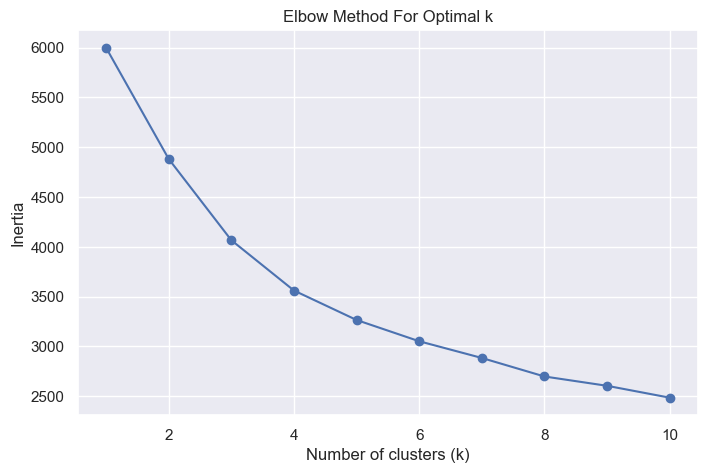

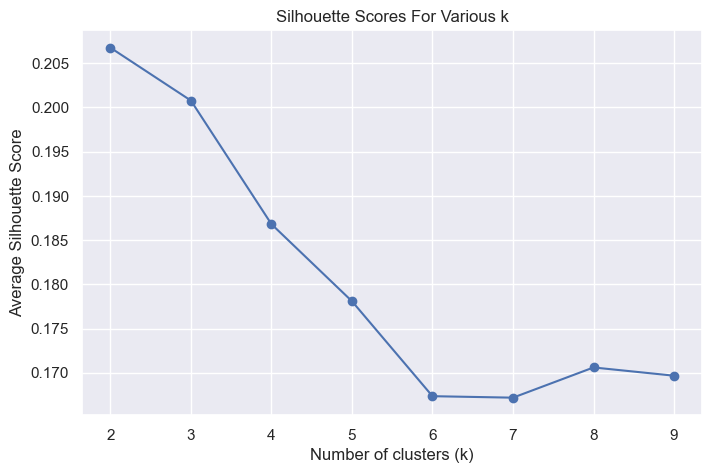

In [91]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the range for K
K = range(1, 11)

# Elbow Method
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(merged_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Silhouette Scores
silhouette_avg = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(merged_scaled)
    silhouette_avg.append(silhouette_score(merged_scaled, cluster_labels))

plt.figure(figsize=(8,5))
plt.plot(range(2,10), silhouette_avg, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Scores For Various k')
plt.show()


Based on these results, we'll choose k = ... TODO: decidere

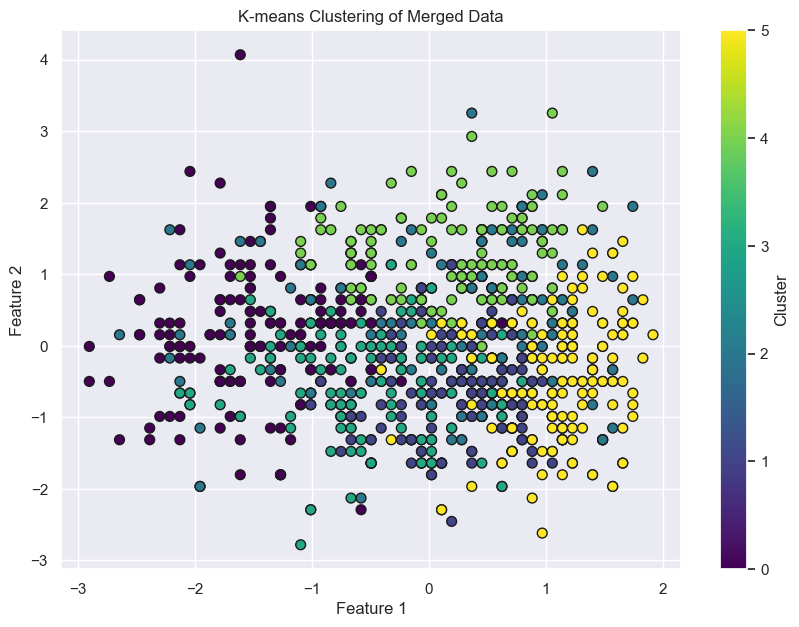

In [92]:
kmeans = KMeans(n_clusters=6, random_state=42)
merged_features['kmeans_cluster'] = kmeans.fit_predict(merged_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 7))
plt.scatter(merged_scaled[:, 0], merged_scaled[:, 1], c=merged_features['kmeans_cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('K-means Clustering of Merged Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

In [93]:
kmeans_clusters = merged_features.groupby('kmeans_cluster').mean()
print("KMeans Cluster Profiles:")
print(kmeans_clusters)

KMeans Cluster Profiles:
                 birth_year     weight  races_participated  climb_total  \
kmeans_cluster                                                            
0               1962.821192  68.701987          194.158940  2118.072848   
1               1982.465241  64.737968          573.417112  2436.989305   
2               1980.868966  69.855172          278.627586  3999.572414   
3                1974.91358  64.722222          206.956790  1243.697531   
4               1982.126437  75.218391          358.660920  1731.310345   
5               1992.220994  65.541436          167.165746       2347.0   

                startlist_quality        delta  
kmeans_cluster                                  
0                     1722.774834   249.635762  
1                     1167.716578   249.192513  
2                     1207.248276  1471.448276  
3                     1028.104938   126.061728  
4                     1076.074713   246.275862  
5                      879.9613

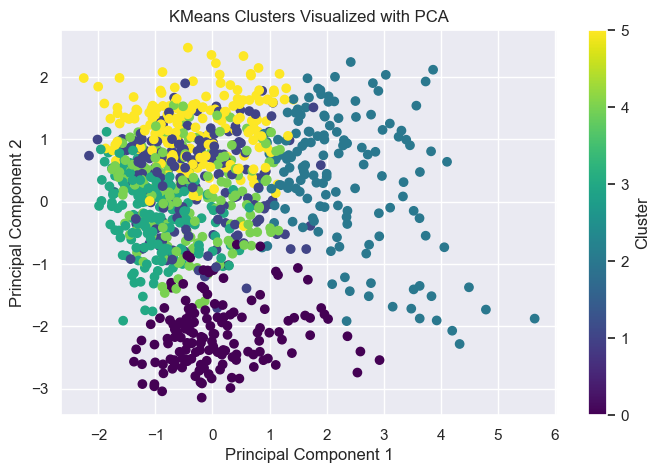

In [94]:
# We'll use PCA to reduce dimensionality for visualization.

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
merged_pca = pca.fit_transform(merged_scaled)

plt.figure(figsize=(8,5))
plt.scatter(merged_pca[:,0], merged_pca[:,1], c=merged_features['kmeans_cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clusters Visualized with PCA')
plt.colorbar(label='Cluster')
plt.show()

# DBSCAN Clustering

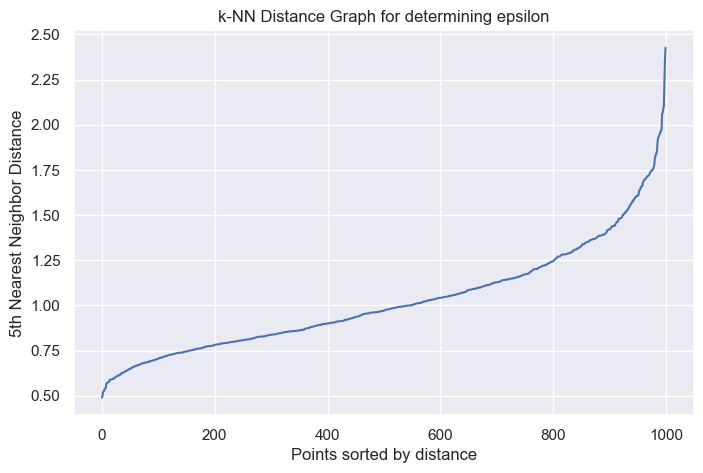

In [95]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Determine optimal epsilon using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(merged_scaled)
distances, indices = neighbors_fit.kneighbors(merged_scaled)

distances = np.sort(distances[:,4], axis=0)
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('k-NN Distance Graph for determining epsilon')
plt.show()

Based on the k-distance graph, we'll choose `eps = ...`. TODO: decidere e aggiornare sotto

In [96]:
# Perform DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
cyclists_features['dbscan_cluster'] = dbscan.fit_predict(cyclists_scaled)

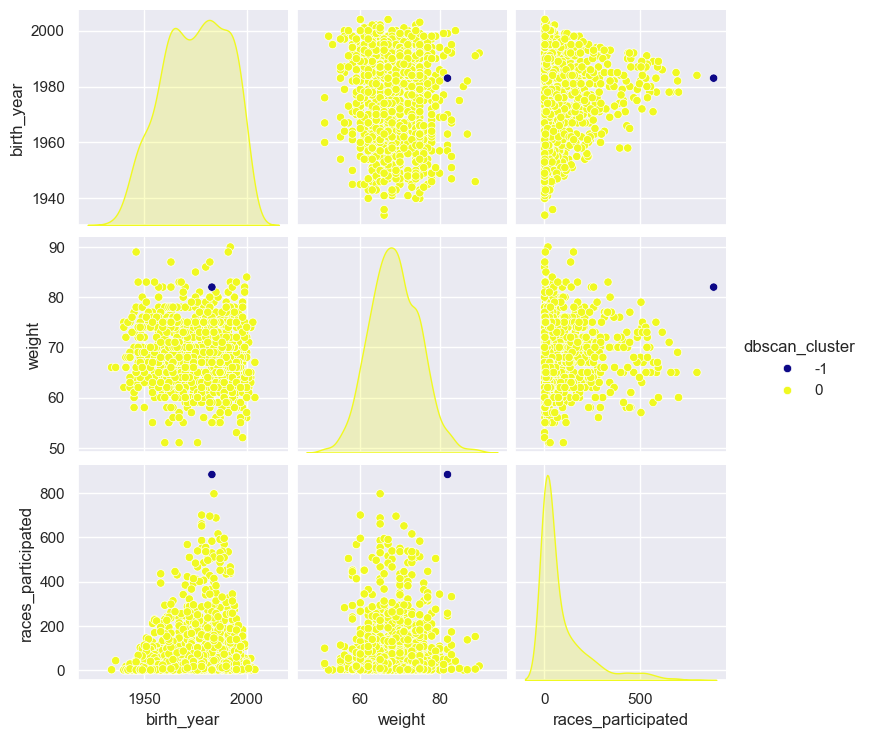

In [97]:
# Pairplot for DBSCAN clusters
sns.pairplot(cyclists_features, hue='dbscan_cluster', palette='plasma')

## Visualizations and analysis

# Hierarchical Clustering

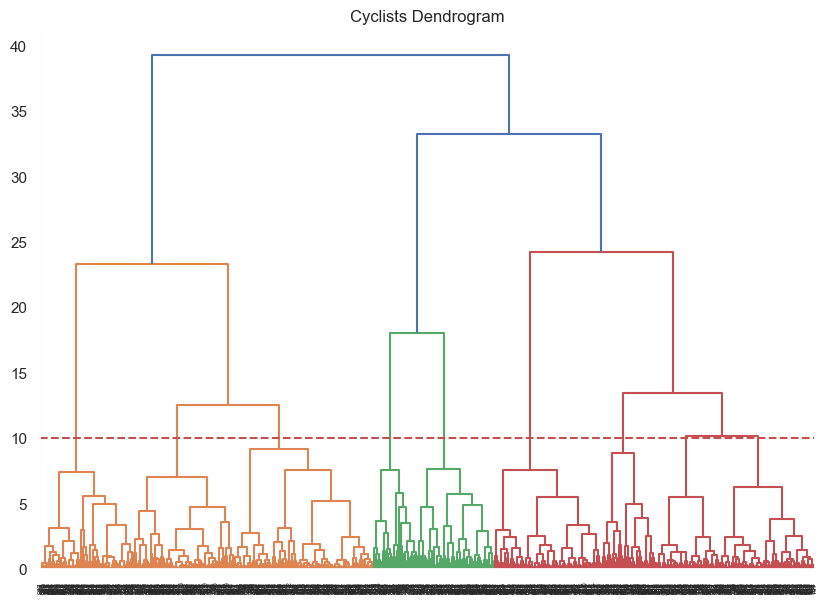

In [98]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Cyclists Dendrogram")
dend = shc.dendrogram(shc.linkage(cyclists_scaled, method='ward'))
plt.axhline(y=10, color='r', linestyle='--') # TODO: scegliere il valore di cutoff
plt.show()

We'll cut the dendrogram at height = ... to get clusters. TODO: decidere e aggiornare TUTTO

In [99]:
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=3)
cyclists_features['hier_cluster'] = hierarchical.fit_predict(cyclists_scaled)

# Cluster Evaluation and Interpretation

# Final observations